# **Mixture of Experts (MoE)**

Real-world engineering processes are often complex, with underlying patterns and behaviors that can vary significantly across different contexts. Modeling these processes effectively requires approaches that can handle such variability and adapt to different scenarios dynamically. In the world of Gaussian Proccesses (GPs) one powerful method for achieving this is the Mixture of Experts model.

A Mixture of Experts model combines multiple expert models to handle different parts of the input space. Each expert is specialized in a particular region or aspect of the data, and a gating network decides which expert (or combination of experts) should be used for a given input. This modular approach allows for more flexible and accurate modeling of complex data.

This notebook will first illustrate how a Mixture of Experts model might be useful, and then cover how to use one in `twinLab`:

1. [Limitations of classic Gaussian Processes.](#1-limitations-of-classic-stationary-Gaussian-Procceses)
2. [How to upload your dataset to the cloud.](#2.1-Upload-dataset-to-be-used)
3. [How to train a Mixture of Experts emulator.](#2.2-Train-your-emulator)
4. [How to plot the results of your Mixture of Experts trained emulator.](#2.3-Plot-the-results-of-trained-emulator)
5. [How to predict using a Mixture of Experts emulator.](#2.4-Predict-using-your-trained-emulator)
6. [How to compare the prediction results of a Mixture of Experts emulator and a standard emulator.](#2.5.-Viewing-and-comparing-the-results)
  

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import twinlab as tl


          ====== TwinLab Client Initialisation ======
          Version     : 2.10.0
          User        : sergio@digilab.co.uk
          Server      : http://127.0.0.1:8000
          Environment : /Users/sergiochavez/twinLab/.env



Make sure you set up your API key and other information to be able to use `twinLab`, either through a `.env` file, using `secrets`, or through `tl.set_user`/`tl.set_api_key`.

### **1. Limitations of classic Gaussian Procceses**

Consider you have an underlying data-generating process, that varies a lot in one part of the data, but less so in other parts of the data. You can generate data like that through the code in the below cell.

In [ ]:
# Define a random seed to ensure your data is randomly generated
np.random.seed(421)


# Define the model that generates the data
def model(x):
    y = (np.sin(np.pi * x / 5) + 0.2 * np.cos(4 * np.pi * x / 5)) * (x <= 9.6)
    lin = x > 9.6
    y[lin] = -1 + x[lin] / 10
    return y


# Create an input (X) and output (y)
X = np.linspace(0, 20, 100)
y = model(X)

We've taken this model as an example from the following paper: _Gramacy, R. B. (2020). Surrogates: Gaussian process modeling, design, and optimization for the applied sciences. CRC Press, Taylor & Francis Group._

Let's define some data from this model and prepare it in a `pandas DataFrame`, which the primary way `twinLab` expects to deal with data. 

In [ ]:
# Define some data
X_data = 20 * np.random.uniform(size=50)
y_data = model(X_data) + 0.1 * np.random.normal(size=X_data.size)
class_data = (X_data > 9.6).astype("float")
df = pd.DataFrame({"X": X_data, "y": y_data, "class": class_data})

Now you can plot that data to better visualize what's going on. 

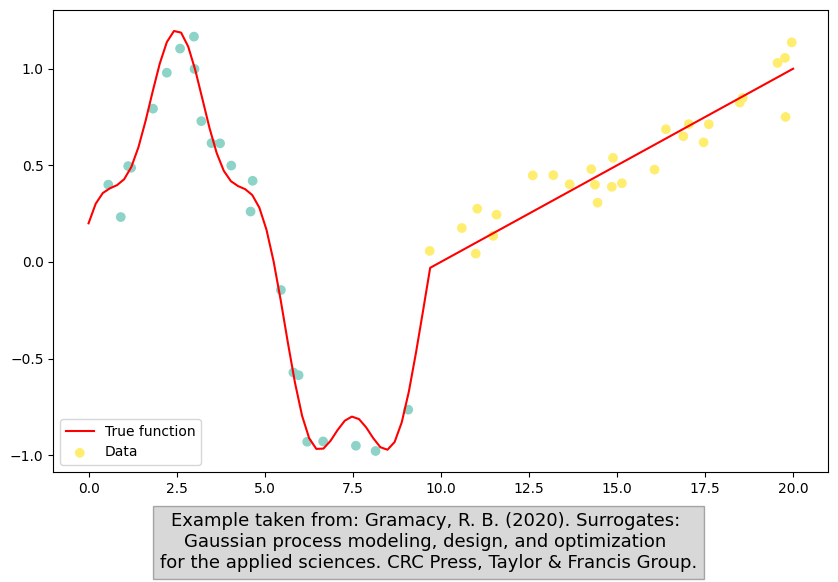

In [2]:
# Plot functions
plt.figure(figsize=(10, 6))
plt.plot(
    X, y, label="True function", c="r"
)  # Plot the model you used to generate the data--the true function
plt.scatter(
    X_data, y_data, c=class_data, label="Data", cmap="Set3"
)  # Data points generated from the function

# Add legend and reference
plt.legend()
plt.show()

Create a `Dataset` with an `id` which is used to access it. Using the `upload` method, you can then upload the `Dataset` to your `twinLab` cloud account.

In [ ]:
# Intialise a Dataset object and give it a name
dataset = tl.Dataset("mixture_of_experts_df")

# Upload the dataset, passing in the dataframe
dataset.upload(df)

Use the `twinLab` `Emulator` class to define an emulator with an `id`, under which your emulator will be saved as in the `twinLab` cloud.

In [ ]:
emulator = tl.Emulator(id="classic_gp_emulator")

Train your model using the `Emulator.train` function, specifying your dataset, inputs, and outputs.

In [ ]:
# Train a standard stationary GP emulator
emulator.train(dataset, inputs=["X"], outputs=["y"])

Visualize your results with `twinLab`. 

Emulator classic_gp_emulator has begun training.
0:00:00: Job status: success
Training of emulator classic_gp_emulator is complete!


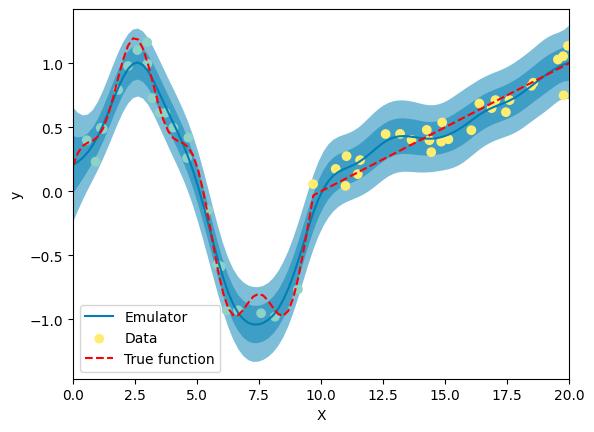

In [3]:
# Plot the emulator
emulator.plot(x_axis="X", y_axis="y", x_lim=(0, 20), color="#007FB3")
# Add in your training data points
plt.scatter(X_data, y_data, c=class_data, label="Data", cmap="Set3")
# Plot the model you used to generate the data--the true function
plt.plot(X, y, label="True function", c="r", linestyle="dashed")

# Add in a legend and show your plot
plt.legend()
plt.show()

The emulator plot shows that the model has a very high predictive variance on the right side of the domain. This happens because the model is only considering functions that fits all the data points, no matter how the patterns changes depending on the input area.

Using a Mixture of Experts model will account for the different regions and patterns of the datapoints, fitting specialized ("expert") GPs to them. 

## **2. How to use `twinLab` to create, train, and use a Mixture of Experts model**

You can now create and train a `twinLab` emulator that uses a Mixture of Experts model with the same model you've just set up. 

### **2.1. Upload dataset to be used**

First, note that you will need the different classes, that are governed by different experts, to be labelled in the training `DataFrame` in advance. Here, they are specified in the "class" column:

In [4]:
# Structure of the dataframe to be uploaded
df.head()

,X,y,class
0,13.655640,0.402193,1.0
1,16.066217,0.477974,1.0
2,1.125503,0.496038,0.0
3,19.769547,1.056062,1.0
4,4.050445,0.498828,0.0


Once again, you need to create a `Dataset` with an `id` which is used to access it. Using the `upload` method, you can then upload the `Dataset` to your `twinLab` cloud account.

In [5]:
# Create your Dataset object and upload data
dataset = tl.Dataset(id="mixture_of_experts_df")
dataset.upload(df)

### **2.2. Train your emulator**

To train a Mixture of Experts models in **twinLab** you will have to:

* Specify the type of estimator you want (***"mixture_of_experts_gp"***) inside **tl.EstimatorParams()**
* Specify the label of the class column (in this case ***"class"***) inside **tl.TrainParams()**
* Include the defined **tl.TrainParams()** inside the training process of the emulator along with the inputs and outputs to be considered from the dataset.

In [6]:
# Set up your emulator
emulator_MoE = tl.Emulator(id="mixture_of_experts_emulator")

# Train the emulator
estimator_params = tl.EstimatorParams(
    estimator_type="mixture_of_experts_gp"
)  # Specify the type of estimator
train_params = tl.TrainParams(
    estimator_params=estimator_params, class_column="class"
)  # Specify the label of the class column that will be used to train the different experts
emulator_MoE.train(
    dataset, inputs=["X"], outputs=["y"], params=train_params
)  # Add train_params as a parameter

Emulator mixture_of_experts_emulator has begun training.
0:00:00: Job status: success
Training of emulator mixture_of_experts_emulator is complete!


### **2.3. Plot the results of trained emulator**

To visualize how the emulator fits the trained data you can use the plot functionality of `twinLab`. 

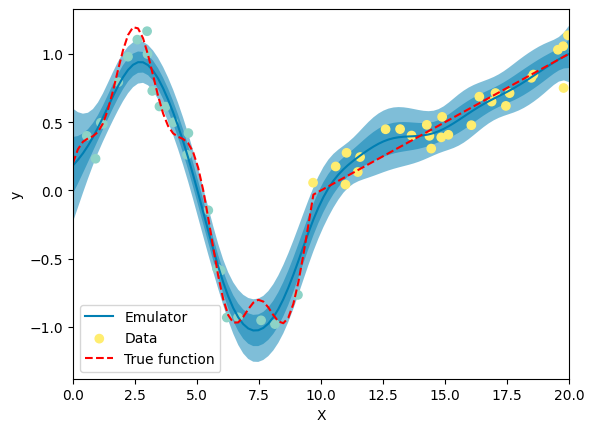

In [7]:
# Plot results of training
emulator_MoE.plot(x_axis="X", y_axis="y", x_lim=(0, 20), color="#007FB3")
# Add in your training data
plt.scatter(X_data, y_data, c=class_data, label="Data", cmap="Set3")
# Plot the model you used to generate the data--the true function
plt.plot(X, y, label="True function", c="r", linestyle="dashed")

# Add in a legend and show your plot
plt.legend()
plt.show()

As you can see, the twinLab Mixture of Experts model fits the training data better than the previous image where a standard stationary GP was used.

### **2.4. Predict using your trained emulator**

Once the emulator is trained, the `twinLab` Mixture of Experts is ready to be used.

Now you can predict the outcome for a new set of datapoints and compare the results with the predictions coming from a standard stationary GP.

First we need to create some data in order to predict against. 

In [8]:
# Change seed to generate different data for evaluation of prediction
np.random.seed(765)

# Generate new input to predict
X = np.linspace(0, 20, 100)

# Generate new input data from the function
X_data = 20 * np.random.uniform(size=20)

# Create a DataFrame
eval_df = pd.DataFrame({"X": X_data})

You can follow the same procedure for creating predictions with `twinLab` for both a standard emulator and an emulator using Mixture of Experts: 

In [9]:
# Predict outcomes using the standard GP emulator
mean_predictions, std_predictions = emulator.predict(eval_df, verbose=False)

# Predict outcomes using the Mixture of Experts GP emulator
mean_predictions_MoE, std_predictions_MoE = emulator_MoE.predict(eval_df, verbose=False)

Now that you've created predictions, let's add it in to your `DataFrame`. 

In [ ]:
# Include predictions of both emulator in the dataframe
eval_df["mean_predictions_MoE"] = mean_predictions_MoE
eval_df["std_predictions_MoE"] = std_predictions_MoE
eval_df["mean_predictions"] = mean_predictions
eval_df["std_predictions"] = std_predictions

### **2.5. Viewing and comparing the results**

You can plot the prediction results to better appreciate the differences in performance between the standard emulator that you've trained, and the emulator where you've used the Mixture of Experts model.


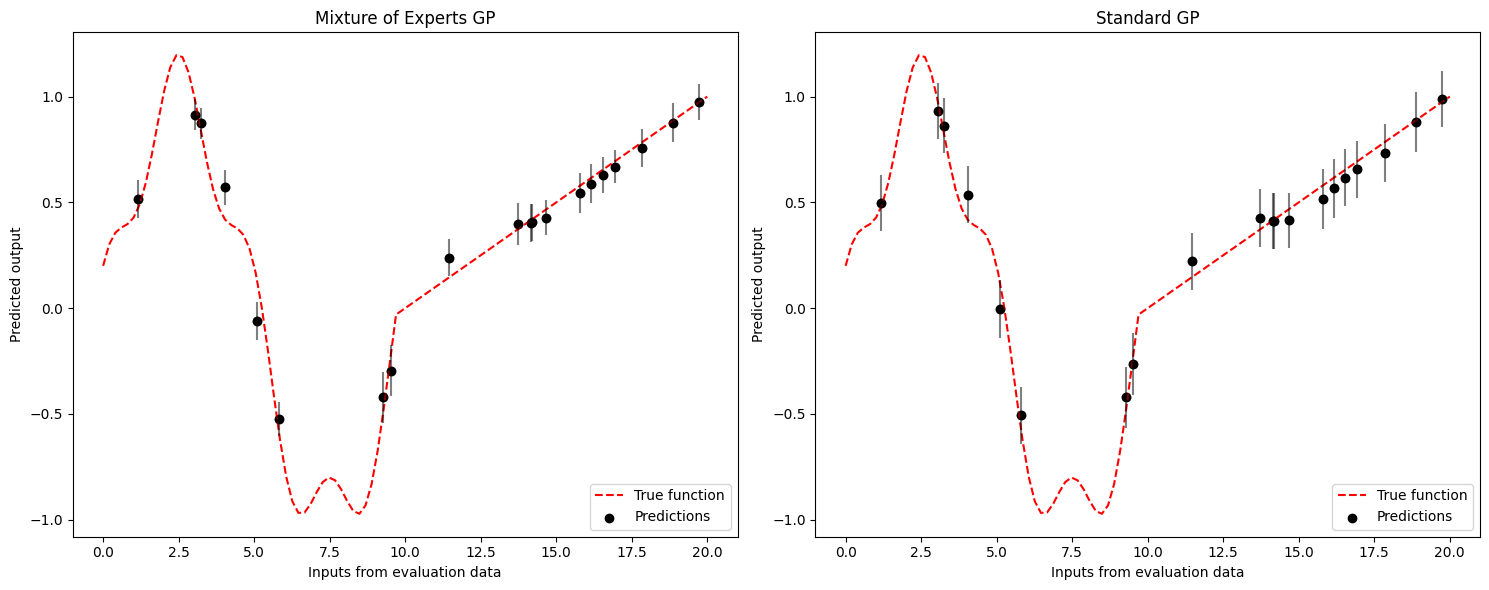

In [10]:
## Plot results
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
# Mixtures of Experts GP
axes[0].plot(
    X, model(X), label="True function", c="r", linestyle="dashed"
)  # Plot the model you used to generate the data--the true function
axes[0].scatter(
    eval_df["X"], eval_df["mean_predictions_MoE"], c="black", label="Predictions"
)  # Add prediction points
axes[0].errorbar(
    eval_df["X"],
    eval_df["mean_predictions_MoE"],
    yerr=eval_df["std_predictions_MoE"],
    fmt="o",
    color="black",
    alpha=0.5,
)  # Add standard deviation for each prediction
axes[0].legend(loc="lower right")  # Move legend to lower right
axes[0].set_xlabel("Inputs from evaluation data")
axes[0].set_ylabel("Predicted output")
axes[0].set_title("Mixture of Experts GP")
# Standard GP
axes[1].plot(
    X, model(X), label="True function", c="r", linestyle="dashed"
)  # Plot the model you used to generate the data--the true function
axes[1].scatter(
    eval_df["X"], eval_df["mean_predictions"], c="black", label="Predictions"
)  # Add prediction points
axes[1].errorbar(
    eval_df["X"],
    eval_df["mean_predictions"],
    yerr=eval_df["std_predictions"],
    fmt="o",
    color="black",
    alpha=0.5,
)  # Add standard deviation for each prediction
axes[1].legend(loc="lower right")  # Move legend to lower right
axes[1].set_xlabel("Inputs from evaluation data")
axes[1].set_ylabel("Predicted output")
axes[1].set_title("Standard GP")
# Display plots
plt.tight_layout()
plt.show()

The plot shows how the predictions of the Mixture of Experts model are more accurate and closer to the underlying real function. This can be better appreciated comparing the error bars of the predictions, where it is showed that the uncertainty is lower than the predictions coming from the standard GP.

### **Deleting datasets and campaigns**

You can delete your datasets and emulators to keep your twinLab cloud account storage tidy. 

Please be aware that this is permanent. Always consider keeping your data locally backed up. 

`Emulator.delete` and `Dataset.delete` delete the emulator and the dataset respectively.

In [11]:
# Delete standard emulator and dataset
emulator.delete()
dataset.delete()

# Delete MoE emulator
emulator_MoE.delete()